In [1]:
!pip install pydicom pillow

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import math
import random
import shutil

import cv2
import pydicom
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm

np.random.seed(42)

In [3]:
CSV_FILE = '../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
TRAIN_SRC_DIR = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/'
TEST_SRC_DIR = '../input/rsna-pneumonia-detection-challenge/stage_2_test_images/'
DATASET_DIR = './dataset/'

os.mkdir(DATASET_DIR)
os.mkdir(DATASET_DIR + 'images/')
os.mkdir(DATASET_DIR + 'images/train/')
os.mkdir(DATASET_DIR + 'images/val/')
os.mkdir(DATASET_DIR + 'images/test/')
os.mkdir(DATASET_DIR + 'labels/')
os.mkdir(DATASET_DIR + 'labels/train/')
os.mkdir(DATASET_DIR + 'labels/val/')
os.mkdir(DATASET_DIR + 'labels/test/')

In [4]:
annots = pd.read_csv(CSV_FILE)
annots = annots[annots.Target == 1]
annots.head()

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1


In [5]:
patient_id_series = annots.patientId.drop_duplicates()

train_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=42)
print('Train set number:', len(train_series))
print('Validation set number:', len(val_series))

Train set number: 5410
Validation set number: 602


In [6]:
for patient_id in train_series:
    src_path = TRAIN_SRC_DIR + patient_id + '.dcm'
    dcm_data = pydicom.dcmread(src_path)
    image_array = dcm_data.pixel_array
    image = Image.fromarray(image_array)
    image.save(DATASET_DIR + 'images/train/' + patient_id + '.jpg')
    
for patient_id in val_series:
    src_path = TRAIN_SRC_DIR + patient_id + '.dcm'
    dcm_data = pydicom.dcmread(src_path)
    image_array = dcm_data.pixel_array
    image = Image.fromarray(image_array)
    image.save(DATASET_DIR + 'images/val/' + patient_id + '.jpg')

In [7]:
def translate_bbox(row):
    img_size = 1024 # rsna defualt image size
    
    top_left_x = row[1]
    top_left_y = row[2]
    absolute_w = row[3]
    absolute_h = row[4]

    relative_w = absolute_w / img_size
    relative_h = absolute_h / img_size
    
    relative_x = top_left_x / img_size + relative_w / 2
    relative_y = top_left_y / img_size + relative_h / 2
    
    return relative_x, relative_y, relative_w, relative_h
    
def revert_bbox(rx, ry, rw, rh):
    img_size = 1024 # rsna defualt image size
    
    x = (rx-rw/2)*img_size
    y = (ry-rh/2)*img_size
    w = rw*img_size
    h = rh*img_size
    
    return x, y, w, h
    
    
def save_label(label_dir, patient_id, row=None):
    label_fp = os.path.join(label_dir, patient_id + '.txt')
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return
    
    x, y, w, h = translate_bbox(row)
    
    line = f"0 {x} {y} {w} {h}\n"
    
    f.write(line)
    f.close()

In [8]:
LABELS_DIR = "./labels_temp/"
os.mkdir(LABELS_DIR)

for row in annots.values:
    patient_id = row[0]
    save_label(LABELS_DIR, patient_id, row)
    
for patient_id in train_series:
    shutil.copy(LABELS_DIR + patient_id + '.txt', DATASET_DIR + 'labels/train/')
    
for patient_id in val_series:
    shutil.copy(LABELS_DIR + patient_id + '.txt', DATASET_DIR + 'labels/val/')
    
os.rmtree(LABELS_DIR)

OSError: [Errno 39] Directory not empty: './labels_temp/'

0 0.32666015625 0.55419921875 0.1669921875 0.2431640625

0 0.63623046875 0.54541015625 0.1298828125 0.2587890625



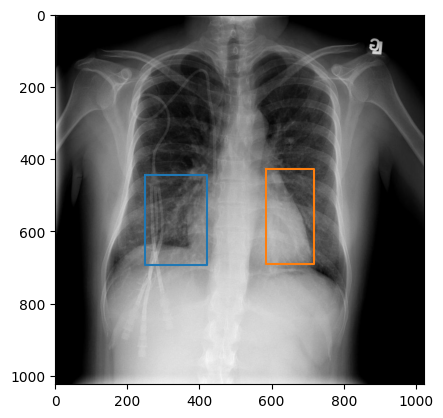

In [ ]:
demo_patient_id = val_series.values[2]
demo_img_path = DATASET_DIR + 'images/val/' + demo_patient_id + '.jpg'
demo_label_path = DATASET_DIR + 'labels/val/' + demo_patient_id + '.txt'

plt.imshow(cv2.imread(demo_img_path))

img_size = 1014
with open(demo_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rx, ry, rw, rh = list(map(float, line.strip().split()))
        
        x, y, w, h = revert_bbox(rx, ry, rw, rh)
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

In [10]:
%%writefile config.yaml

path: '/kaggle/working/dataset' # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val  # val images (relative to 'path')

# Classes
names:
  0: pneumonia

Writing config.yaml


In [12]:
!pip install ultralytics

In [13]:
from ultralytics import YOLO

In [14]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 184MB/s]


In [15]:
results = model.train(data='config.yaml', epochs = 15)

Ultralytics YOLOv8.1.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=15, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 38.1MB/s]
2024-02-07 09:21:06,566	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-07 09:21:07,431	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-07 09:21:10.100572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 09:21:10.100713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 09:21:10.249303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train... 5410 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5410/5410 [00:04<00:00, 1258.09it/s]


train: New cache created: /kaggle/working/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/dataset/labels/val... 602 images, 0 backgrounds, 0 corrupt: 100%|██████████| 602/602 [00:00<00:00, 1433.49it/s]


val: New cache created: /kaggle/working/dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      2.36G          2      2.642       1.93          9        640: 100%|██████████| 339/339 [01:13<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.52it/s]

                   all        602        967      0.491      0.161      0.242     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      2.39G      1.977      2.196       1.86          3        640: 100%|██████████| 339/339 [01:05<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]


                   all        602        967      0.422      0.421      0.376      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      2.39G      1.976      2.131      1.858          2        640: 100%|██████████| 339/339 [01:05<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.68it/s]


                   all        602        967      0.456      0.465      0.407      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      2.38G      1.926      2.058      1.809         10        640: 100%|██████████| 339/339 [01:05<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.88it/s]

                   all        602        967      0.495      0.473      0.438      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      2.39G      1.923      1.979      1.768          4        640: 100%|██████████| 339/339 [01:10<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.74it/s]

                   all        602        967      0.481      0.449      0.432      0.155


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      2.39G      1.983      1.981      1.887          3        640: 100%|██████████| 339/339 [01:05<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.65it/s]


                   all        602        967       0.41      0.481      0.393      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      2.39G      1.945      1.933      1.867          2        640: 100%|██████████| 339/339 [01:06<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.59it/s]


                   all        602        967      0.421      0.498      0.404      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      2.38G      1.951      1.887      1.855          3        640: 100%|██████████| 339/339 [01:07<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.72it/s]


                   all        602        967      0.491      0.522       0.49      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      2.39G      1.923      1.863       1.83          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.79it/s]


                   all        602        967      0.522      0.544      0.495      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      2.39G       1.91      1.837       1.81          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.40it/s]

                   all        602        967      0.474      0.517      0.475      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      2.39G      1.894      1.817        1.8          4        640: 100%|██████████| 339/339 [01:07<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.61it/s]


                   all        602        967      0.482      0.552      0.489      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      2.38G      1.883      1.792      1.798          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.78it/s]


                   all        602        967      0.504      0.578      0.512      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      2.39G      1.852       1.76      1.784          3        640: 100%|██████████| 339/339 [01:03<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.72it/s]


                   all        602        967      0.528      0.552      0.511      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      2.39G      1.832      1.739       1.76          4        640: 100%|██████████| 339/339 [01:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.67it/s]

                   all        602        967      0.526      0.578       0.52      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      2.39G      1.825      1.724      1.755          4        640: 100%|██████████| 339/339 [01:03<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.73it/s]

                   all        602        967      0.527      0.582      0.544      0.215



15 epochs completed in 0.299 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.07it/s]


                   all        602        967      0.525       0.58      0.543      0.215
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▃▆█▇▇▇▆▅▅▄▄▃▂▂▁
lr/pg1,▃▆█▇▇▇▆▅▅▄▄▃▂▂▁
lr/pg2,▃▆█▇▇▇▆▅▅▄▄▃▂▂▁
metrics/mAP50(B),▁▄▅▆▅▅▅▇▇▆▇▇▇▇█
metrics/mAP50-95(B),▁▃▄▅▅▄▅▇▇▆▇▇▇██
metrics/precision(B),▆▂▄▆▅▁▂▆█▅▅▇███
metrics/recall(B),▁▅▆▆▆▆▇▇▇▇█████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇▅▅▇▆▆▅▄▄▃▂▁▁


In [70]:
def plot_val_pred(demo_patient_id, verbose=True):
    demo_img_path = DATASET_DIR + 'images/val/' + demo_patient_id + '.jpg'
    demo_label_path = DATASET_DIR + 'labels/val/' + demo_patient_id + '.txt'

    res = model(demo_img_path, verbose=verbose)
    if verbose:
        print(res[0].probs)
        print(res[0].boxes.xywh)

    plt.imshow(cv2.imread(demo_img_path))

    img_size = 1014
    with open(demo_label_path, "r") as f:
        for line in f:
            if verbose:
                print(line)
            class_id, rx, ry, rw, rh = list(map(float, line.strip().split()))

            x, y, w, h = revert_bbox(rx, ry, rw, rh)
            plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y], c='blue')

    for box in res[0].boxes.xywh.cpu():
        px, py, pw, ph = box
        plt.plot([px, px, px+pw, px+pw, px], [py, py+ph, py+ph, py, py], c='orange')

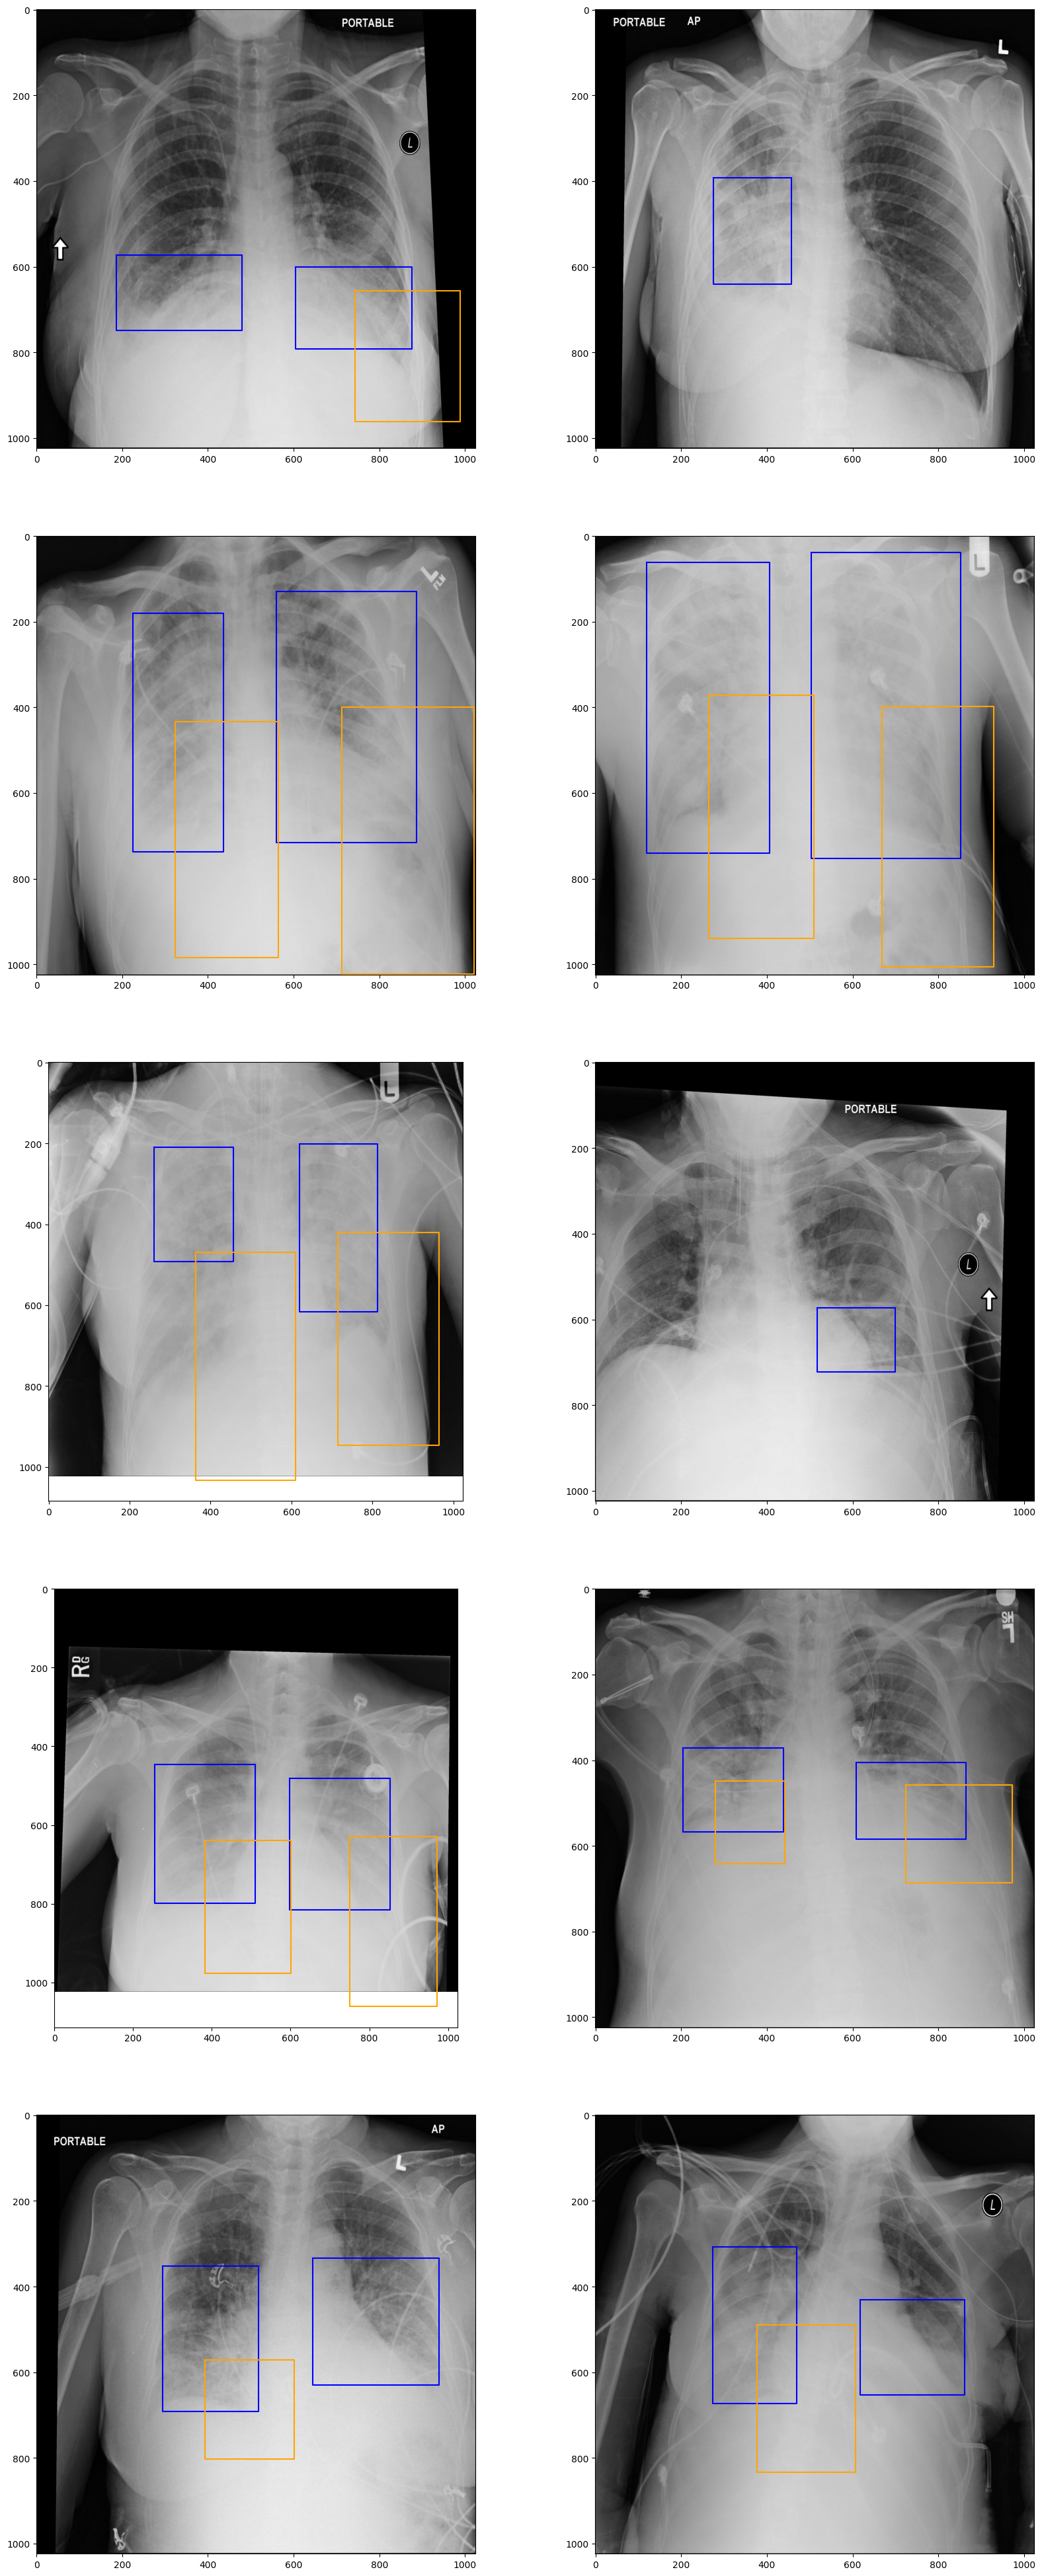

In [83]:
def random_value(series):
    return series.iloc[random.randrange(0, len(series))]

rows = 5
cols = 2
plt.figure(figsize=(20,50))
# plot_val_pred(random_value(val_series), verbose=False)
for h in range(rows):
    for w in range(cols):
        plt.subplot(rows, cols, h*2+w+1)
        plot_val_pred(random_value(val_series), verbose=False)